# Botnet multiclass detection using NetTiSA flows

In [1]:
import pandas as pd
import numpy as np
import json
import collections

import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import seaborn as sns

#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
import lightgbm as lgb
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier


from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from collections import Counter
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss


In [2]:
df = pd.read_csv("../final_datasets/botnet_multiclass.csv")

In [3]:
df

,Unnamed: 0,SRC_IP,DST_IP,SRC_PORT,DST_PORT,TIME_FIRST,TIME_LAST,LABEL,PACKETS,PACKETS_REV,...,ROOT_MEAN_SQUARE,KURTOSIS,TIME_DISTRIBUTION,MEAN_RELATIVE_TIME,DURATION,MEAN_DIFFTIMES,MIN_DIFFTIMES,MAX_DIFFTIMES,SWITCHING_METRIC,DIRECTIONS
0,0,147.32.84.165,147.32.80.9,1025,53,1.312967e+09,1.312967e+09,neris,4,2,...,235.084382,2.796482,0.497004,1.131372,2.276383,0.455277,0.000006,2.254977,1.200000,0.666667
1,1,147.32.84.165,147.32.84.255,137,137,1.312967e+09,1.312967e+09,clear,38,0,...,125.329881,4.164066,0.428112,5.330970,12.452268,0.336548,0.000000,1.763265,0.324324,1.000000
2,2,147.32.84.165,147.32.84.255,138,138,1.312967e+09,1.312967e+09,clear,6,0,...,253.565245,0.986151,0.666641,2.675396,4.013247,0.802649,0.000011,4.012922,0.800000,1.000000
3,3,60.190.222.139,147.32.84.165.,65520,1039,1.312967e+09,1.312967e+09,clear,4,0,...,163.003834,1.318585,0.339969,0.866065,2.547480,0.849160,0.305220,1.936479,0.666667,1.000000
4,4,147.32.84.165,60.190.222.139.,1039,65520,1.312967e+09,1.312967e+09,clear,10,0,...,76.264015,2.103153,0.283852,0.843926,2.973125,0.330347,0.000007,2.353862,0.666667,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176729,176729,147.32.84.165,64.142.97.114.,10000,20346,1.313558e+09,1.313558e+09,clear,2,0,...,60.000000,0.000000,0.500000,0.000005,0.000010,0.000010,0.000010,0.000010,0.000000,1.000000
176730,176730,95.130.170.231,147.32.84.165.,29083,80,1.313563e+09,1.313563e+09,clear,1,0,...,60.000000,0.000000,NaN,0.000000,0.000000,NaN,NaN,NaN,0.000000,1.000000
176731,176731,147.32.84.165,95.130.170.231.,80,29083,1.313563e+09,1.313563e+09,clear,2,0,...,60.000000,0.000000,0.500000,0.000005,0.000009,0.000009,0.000009,0.000009,0.000000,1.000000
176732,176732,199.59.164.114,147.32.84.165.,80,40924,1.313565e+09,1.313565e+09,clear,2,0,...,60.000000,0.000000,0.500000,0.000017,0.000033,0.000033,0.000033,0.000033,0.000000,1.000000


In [74]:
default_faetures = [
    "PACKETS",
    "PACKETS_REV",
    "BYTES",
    "BYTES_REV",
]

features = [
    "PACKETS",
    "PACKETS_REV",
    "BYTES",
    "BYTES_REV",
    "MEAN",
    "STDEV",
    "VAR",
    "BURSTINESS",
    "MIN",
    "MAX",
    "MIN_MINUS_MAX",
    "COEFFICIENT_OF_VARIATION",
    "AVERAGE_DISPERSION",
    "PERCENT_DEVIATION",
    "ROOT_MEAN_SQUARE",
    "KURTOSIS",
    "TIME_DISTRIBUTION",
    "MEAN_RELATIVE_TIME",
    "DURATION",
    "MEAN_DIFFTIMES",
    "MIN_DIFFTIMES",
    "MAX_DIFFTIMES",
    "SWITCHING_METRIC",
    "DIRECTIONS",
]

In [75]:
import sklearn
pd.set_option('display.max_columns', None)

df = df[["LABEL"] + features].copy()

df['LABEL'] = df.LABEL.astype('category')
df["LABEL_code"] = df["LABEL"].cat.codes


for F in features:
    df.replace([np.inf], 0, inplace=True)
    df.replace([-np.inf], 0, inplace=True)
    df.loc[df[F].isnull(), F] = 0

In [76]:
df

,LABEL,PACKETS,PACKETS_REV,BYTES,BYTES_REV,MEAN,STDEV,VAR,BURSTINESS,MIN,MAX,MIN_MINUS_MAX,COEFFICIENT_OF_VARIATION,AVERAGE_DISPERSION,PERCENT_DEVIATION,ROOT_MEAN_SQUARE,KURTOSIS,TIME_DISTRIBUTION,MEAN_SCALED_TIME,DURATION,MEAN_DIFFTIMES,MIN_DIFFTIMES,MAX_DIFFTIMES,SWITCHING_METRIC,DIRECTIONS,LABEL_code
0,neris,4,2,134,558,175,171.542998,29427,-0.009976,82,521,439,98.024570,115,65.714286,235.084382,2.796482,0.497004,1.131372,2.276383,0.455277,0.000006,2.254977,1.200000,0.666667,3
1,clear,38,0,2476,0,125,6.633250,44,-0.899216,110,128,18,5.306600,4,3.200000,125.329881,4.164066,0.428112,5.330970,12.452268,0.336548,0.000000,1.763265,0.324324,1.000000,0
2,clear,6,0,1160,0,253,11.874342,141,-0.910340,238,261,23,4.693416,10,3.952569,253.565245,0.986151,0.666641,2.675396,4.013247,0.802649,0.000011,4.012922,0.800000,1.000000,0
3,clear,4,0,249,0,122,124.498996,15500,0.010138,60,309,249,102.048357,93,76.229508,163.003834,1.318585,0.339969,0.866065,2.547480,0.849160,0.305220,1.936479,0.666667,1.000000,0
4,clear,10,0,138,0,73,20.248457,411,-0.565710,60,109,49,27.737612,16,21.917808,76.264015,2.103153,0.283852,0.843926,2.973125,0.330347,0.000007,2.353862,0.666667,1.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176729,clear,2,0,0,0,60,0.000000,0,-1.000000,60,60,0,0.000000,0,0.000000,60.000000,0.000000,0.500000,0.000005,0.000010,0.000010,0.000010,0.000010,0.000000,1.000000,0
176730,clear,1,0,0,0,60,60.000000,0,0.000000,60,60,0,100.000000,0,0.000000,60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0
176731,clear,2,0,0,0,60,0.000000,0,-1.000000,60,60,0,0.000000,0,0.000000,60.000000,0.000000,0.500000,0.000005,0.000009,0.000009,0.000009,0.000009,0.000000,1.000000,0
176732,clear,2,0,0,0,60,0.000000,0,-1.000000,60,60,0,0.000000,0,0.000000,60.000000,0.000000,0.500000,0.000017,0.000033,0.000033,0.000033,0.000033,0.000000,1.000000,0


In [77]:
df[["LABEL", "LABEL_code"]].drop_duplicates().sort_values("LABEL_code")

,LABEL,LABEL_code
1,clear,0
160181,donbot,1
94631,fast_flux,2
0,neris,3
165111,qvod,4
50019,rbot,5
165021,sogou,6


In [78]:
df.LABEL.value_counts()

clear        165664
neris          6332
fast_flux      4367
qvod            286
rbot             55
donbot           27
sogou             3
Name: LABEL, dtype: int64

In [79]:
df = df[df.LABEL != "sogou"]

In [80]:
df[["LABEL", "LABEL_code"]].drop_duplicates().sort_values("LABEL_code")

,LABEL,LABEL_code
1,clear,0
160181,donbot,1
94631,fast_flux,2
0,neris,3
165111,qvod,4
50019,rbot,5


In [81]:
classifications_array = []
for index, row in df[["LABEL", "LABEL_code"]].drop_duplicates().sort_values("LABEL_code").iterrows():
    classifications_array.append(row[0])
classifications_array

['clear', 'donbot', 'fast_flux', 'neris', 'qvod', 'rbot']

In [82]:
df = df[["LABEL_code"] + features].copy()

In [83]:
# df.replace([np.inf], 0, inplace=True)
# df.replace([-np.inf], 0, inplace=True)

In [84]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

df = clean_dataset(df)

In [85]:
df.shape

(176731, 25)

In [86]:
df_validation = df.sample(n = 25000)
df_features =  df[~df.isin(df_validation)].dropna()

In [87]:
def get_confusion_matrix(y_test, y_pred):
    # Get and reshape confusion matrix data
    matrix = confusion_matrix(y_test, y_pred)
    percentage_matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    return matrix, percentage_matrix

def plot_confusion_matrix(matrix, percentage_matrix, model=""):
    # Build the plot
    fig, ax = plt.subplots(1, 2,figsize=(15,5))
    sns.set(font_scale=1.4)
    sns.heatmap(matrix, annot=True, annot_kws={'size':10}, fmt='g',
                cmap=plt.cm.Greens, linewidths=0.2, ax=ax[0])
    sns.heatmap(percentage_matrix, annot=True, annot_kws={'size':10}, fmt='g',
                cmap=plt.cm.Greens, linewidths=0.2, ax=ax[1])
    # Add labels to the plot
    plt.tick_params(axis='both', which='minor', labelsize=5)
    # tick_marks = np.arange(len(classifications_array)) + 0.5
    # plt.xticks(tick_marks, classifications_array, rotation=85)
    # plt.yticks(tick_marks, classifications_array, rotation=0)
    ax[0].set_xlabel('Predicted label')
    ax[0].set_ylabel('True label')
    ax[0].set_title(f'Absolute Confusion Matrix for {model}')
    ax[1].set_xlabel('Predicted label')
    ax[1].set_ylabel('True label')
    ax[1].set_title(f'Relative Confusion Matrix for {model}')
    # pyplot.savefig("ddos_timeseries_plugin_classification.eps", format="eps")
    plt.show()

In [88]:
X = df_features[features]
y = df_features.LABEL_code
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [89]:
y_train.value_counts()

0.0    99565
3.0     3778
2.0     2647
4.0      173
5.0       33
1.0       15
Name: LABEL_code, dtype: int64

In [90]:
y_test.value_counts()

0.0    42671
3.0     1619
2.0     1135
4.0       74
5.0       14
1.0        7
Name: LABEL_code, dtype: int64

In [91]:
df_validation["LABEL_code"].value_counts()

0.0    23428
3.0      935
2.0      585
4.0       39
5.0        8
1.0        5
Name: LABEL_code, dtype: int64

In [64]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import mean_absolute_error

def tunne_together_XGBoost_classification(df_tunne, _features, verbose=True):
    
    def objective(space):
        clf = XGBClassifier(
                        n_estimators = int(space['n_estimators']), max_depth = int(space['max_depth']), gamma = space['gamma'],
                        reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                        colsample_bytree=int(space['colsample_bytree']), 
                        # subsample=int(space['subsample']),
                        # eta=space['eta'],
                            )

        evaluation = [( X_train, y_train), ( X_test, y_test)]

        clf.fit(X_train, y_train,
                eval_set=evaluation, eval_metric="auc",
                early_stopping_rounds=10,verbose=False)

        pred = clf.predict(X_test)
        # accuracy = mean_absolute_error(y_test, pred)
        # accuracy = accuracy_score(y_test, pred)
        accuracy = f1_score(y_test, pred,average='weighted')
        if verbose is True:
            print ("SCORE:", accuracy, "  ", space)
        return {'loss': -accuracy, 'status': STATUS_OK }
    
    space={'max_depth': hp.quniform("max_depth", 5, 60, 5),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 0,90,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0, 1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 20, 1),
        'n_estimators': hp.quniform('n_estimators', 100, 600, 50),
        # 'subsample': hp.quniform('subsample', 3, 20, 1),
        # 'eta': hp.quniform('eta', 0.005, 0.3, 0.005),
        'seed': 0
    }
    
    trials = Trials()
    
    best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)
        
    print("The best hyperparameters are : ","\n")
    print(best_hyperparams)
    return best_hyperparams

In [24]:
best_hyperparams = tunne_together_XGBoost_classification(df_features, features, verbose=False)

100%|██████████| 100/100 [15:21<00:00,  9.22s/trial, best loss: -0.9964210177864843]
The best hyperparameters are :  

{'colsample_bytree': 0.8630538839551367, 'gamma': 1.0695933519681866, 'max_depth': 55.0, 'min_child_weight': 2.0, 'n_estimators': 600.0, 'reg_alpha': 0.0, 'reg_lambda': 0.6757682764131987}


In [92]:
def XGBoost_classification_tunned_old(best_hyperparams, X_train=None, X_test=None, y_train=None, y_test=None):
      if X_train is None:
            X=df_features[features]  # Features
            y=df_features['LABEL_code']  # Labels
            #Split on train and test
            X_train_a, X_test_a, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y) # 70% training and 30% test
            X_train = X_train_a[features]
            X_test = X_test_a[features] 
      
      model = XGBClassifier(
            n_estimators = int(best_hyperparams['n_estimators']), max_depth = int(best_hyperparams['max_depth']), gamma = best_hyperparams['gamma'],
            reg_alpha = int(best_hyperparams['reg_alpha']),min_child_weight=int(best_hyperparams['min_child_weight']),
            colsample_bytree=int(best_hyperparams['colsample_bytree']),
            # subsample=int(best_hyperparams['subsample']),
            # eta=best_hyperparams['eta'],
      )
      model.fit(X_train, y_train)
      y_pred = model.predict(X_test)
      
      print(classification_report(y_test, y_pred, target_names=classifications_array, digits=4))
      matrix, percentage_matrix = get_confusion_matrix(y_test, y_pred)
      plot_confusion_matrix(matrix, percentage_matrix, model="XGBoost")
      return model

              precision    recall  f1-score   support

       clear     0.9997    1.0000    0.9998     42671
      donbot     1.0000    0.8571    0.9231         7
   fast_flux     0.9572    0.9260    0.9413      1135
       neris     0.9441    0.9704    0.9571      1619
        qvod     1.0000    0.8378    0.9118        74
        rbot     0.8571    0.4286    0.5714        14

    accuracy                         0.9966     45520
   macro avg     0.9597    0.8366    0.8841     45520
weighted avg     0.9966    0.9966    0.9965     45520



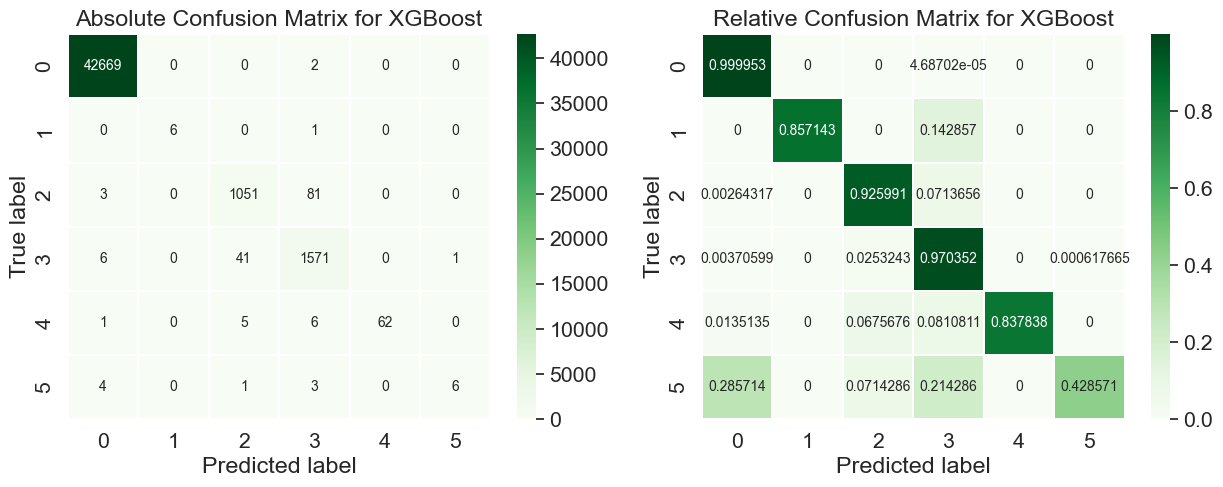

In [93]:
model = XGBoost_classification_tunned_old(best_hyperparams, X_train, X_test, y_train, y_test)

In [27]:

def while_XGBoost_classification_tunned_old(best_hyperparams, cycles=100):
    X=df_features[features]  # Features
    y=df_features['LABEL_code']  # Labels
    best = 0
    best_model = None
    report = None
    i = 0
    print(f"\r{i}", end="")
    for i in range(cycles):
        print(f"\r{i}", end="", flush=True)
        tmp_f1 = 0
        tmp_str = ""
        #Split on train and test
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y) # 70% training and 30% test
        # sm = SMOTE(random_state=100)
        # X_train, y_train = sm.fit_resample(X_train, y_train)
        # X_test, y_test = sm.fit_resample(X_test, y_test)
        
        model = XGBClassifier(
            n_estimators = int(best_hyperparams['n_estimators']), max_depth = int(best_hyperparams['max_depth']), gamma = best_hyperparams['gamma'],
            reg_alpha = int(best_hyperparams['reg_alpha']),min_child_weight=int(best_hyperparams['min_child_weight']),
            colsample_bytree=int(best_hyperparams['colsample_bytree']),
            # subsample=int(best_hyperparams['subsample']),
            # eta=best_hyperparams['eta'],
        )
        model.fit(X_train, y_train, ) # eval_set=evaluation, eval_metric=["auc","error","logloss"], verbose=False
        y_pred = model.predict(X_test)
        
        F1 = f1_score(y_test, y_pred, average='macro')
        if F1 > best:   
            best = F1
            best_model = model
            report = classification_report(y_test, y_pred, target_names=classifications_array, digits=4)
        
    print("")
    print(report)
    return best_model

In [28]:
best_model = while_XGBoost_classification_tunned_old(best_hyperparams, cycles=25)

24
              precision    recall  f1-score   support

       clear     0.9998    0.9999    0.9998     42661
      donbot     1.0000    1.0000    1.0000         7
   fast_flux     0.9591    0.9345    0.9467      1130
       neris     0.9504    0.9743    0.9622      1632
        qvod     1.0000    0.8684    0.9296        76
        rbot     1.0000    0.4286    0.6000        14

    accuracy                         0.9970     45520
   macro avg     0.9849    0.8676    0.9064     45520
weighted avg     0.9970    0.9970    0.9969     45520



              precision    recall  f1-score   support

       clear     0.9998    1.0000    0.9999     23428
      donbot     1.0000    0.6000    0.7500         5
   fast_flux     0.9742    0.9675    0.9708       585
       neris     0.9809    0.9872    0.9840       935
        qvod     1.0000    0.9744    0.9870        39
        rbot     1.0000    0.5000    0.6667         8

    accuracy                         0.9985     25000
   macro avg     0.9925    0.8382    0.8931     25000
weighted avg     0.9985    0.9985    0.9984     25000



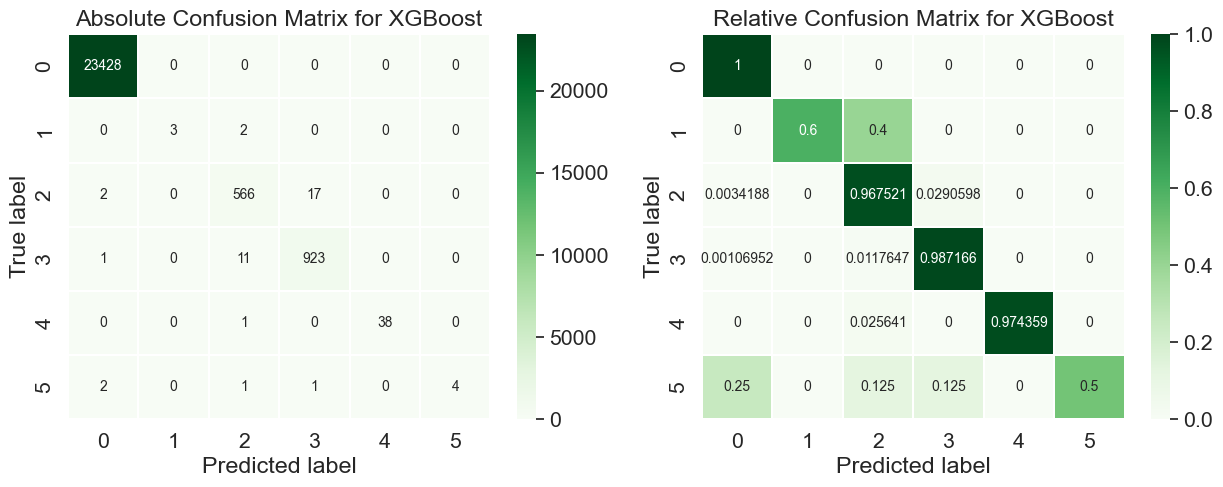

In [94]:
X_validation=df_validation[features]  # Features
y_validation=df_validation['LABEL_code']  # Labels
    

y_pred = best_model.predict(X_validation)

print(classification_report(y_validation, y_pred, target_names=classifications_array, digits=4))

matrix, percentage_matrix = get_confusion_matrix(y_validation, y_pred)
plot_confusion_matrix(matrix, percentage_matrix, model="XGBoost")

# Feature importance

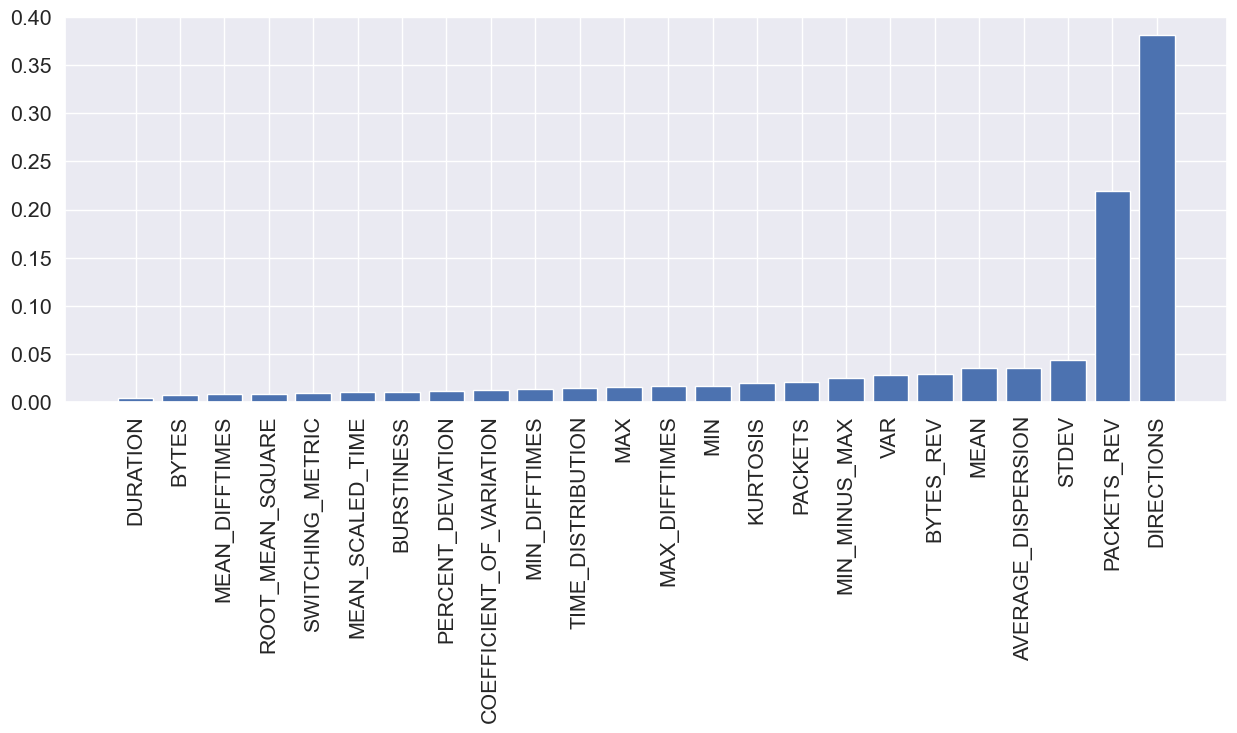

In [95]:
feat_importances = pd.Series(best_model.feature_importances_, index = X_validation.columns).sort_values(ascending = True)
fig, ax = plt.subplots(figsize=(15,5))
ax.bar(feat_importances.keys(), feat_importances.values)
plt.xticks(rotation = 90)
plt.show()

In [97]:
dict(feat_importances)

{'DURATION': 0.00471846,
 'BYTES': 0.0076590506,
 'MEAN_DIFFTIMES': 0.008837404,
 'ROOT_MEAN_SQUARE': 0.008856678,
 'SWITCHING_METRIC': 0.009125341,
 'MEAN_SCALED_TIME': 0.010822259,
 'BURSTINESS': 0.010878699,
 'PERCENT_DEVIATION': 0.011752807,
 'COEFFICIENT_OF_VARIATION': 0.012013229,
 'MIN_DIFFTIMES': 0.013523947,
 'TIME_DISTRIBUTION': 0.014547596,
 'MAX': 0.015449252,
 'MAX_DIFFTIMES': 0.017113185,
 'MIN': 0.017131079,
 'KURTOSIS': 0.019990949,
 'PACKETS': 0.020668704,
 'MIN_MINUS_MAX': 0.02448845,
 'VAR': 0.028327653,
 'BYTES_REV': 0.028638449,
 'MEAN': 0.035192706,
 'AVERAGE_DISPERSION': 0.03547768,
 'STDEV': 0.04413677,
 'PACKETS_REV': 0.21960288,
 'DIRECTIONS': 0.38104668}